<h2> Keras Project 2: 
     </h2>

In [0]:
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.engine import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import Sequential
warnings.filterwarnings('ignore')

We are using CIFAR Dataset for this project

CIFAR-10  is an established computer-vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.There images of about 10 classes in our CIFAR dataset. Different class labels in our Cifar dataset are

In [137]:
label_dict = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
df=pd.DataFrame(label_dict)
print(df)             

            0
0    airplane
1  automobile
2        bird
3         cat
4        deer
5         dog
6        frog
7       horse
8        ship
9       truck


In [0]:
#Loading Cifar DataSet
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

<h2>Question 1</h2>

(40 points) Augmentation: Show how to add augmentation to your training data. Describe both the augmentation being applied, how it's done in the code, and show examples of the augmentation (e.g., different image manipulations)

Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. 
Commonly used Data augmentation techniques to train large neural networks are
<li>1.cropping</li>
<li>2.padding</li>
<li>3.flipping </li>
Data Augmentation increases the robustness of our model as our model will be trained with more data 

We will be taking a sample Image from our training data and will perform different types of augmentation on this sample image 

**Sample Image**

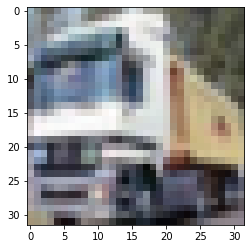

In [139]:
plt.imshow(X_train[1])# sample image from the CIFAR dataset
plt.show()

In [0]:
def plot_image(img,datagen):# This function is used the images of augmented training image
		datagen.fit(img)
		it = datagen.flow(img)
		fig, rows = plt.subplots(nrows = 1,ncols = 3,figsize=(10,10))
		for r in rows:
			r.imshow(it.next()[0].astype('int'))
			r.axis('off')
		plt.show()

**Using flipping:** 
By using flipping we can either flip the image vertically or horizontally

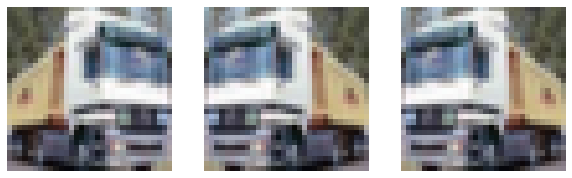

In [141]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    )#Flipping the image horizontally
image=X_train[1]
img = image.reshape((1, image.shape[0],image.shape[1],image.shape[2]))
plot_image(img,datagen)

**Using Rotation:** By using rotation augmentation we can rotate the image with ceratain amount of angle mentioned

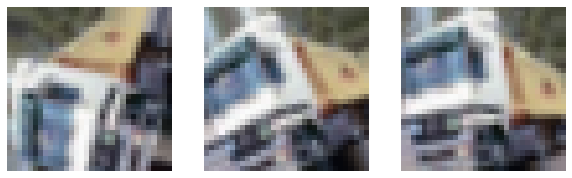

In [142]:
datagen = ImageDataGenerator(
    rotation_range=90,
    )#rotating the image by an angle of 90 degrees
image=X_train[1]
img = image.reshape((1, image.shape[0],image.shape[1],image.shape[2]))
plot_image(img,datagen)

**Using Vertical Shift Augmentation**  By using vertical shift  augmentation we can shift the image vertically


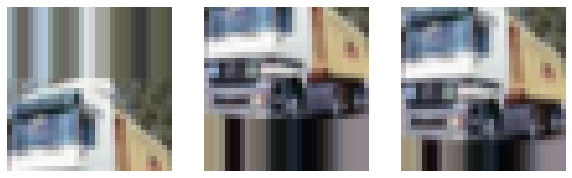

In [143]:
datagen = ImageDataGenerator(height_shift_range=0.5)# Shifting the image vertically by 0.5
image=X_train[1]
img = image.reshape((1, image.shape[0],image.shape[1],image.shape[2]))
plot_image(img,datagen)

**Using Random Brightness Augmentation**:By using Random Brightness Augmentation we can adjust the brighness of our image

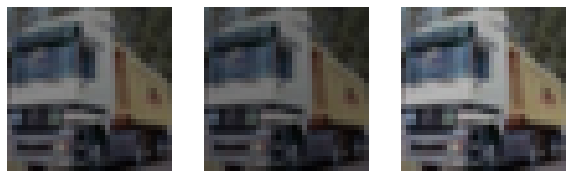

In [144]:
datagen = ImageDataGenerator(brightness_range=[0.2,1.0])# we are using a brightness range of [0.2,0.1] on our testing sample
image=X_train[1]
img = image.reshape((1, image.shape[0],image.shape[1],image.shape[2]))
plot_image(img,datagen)

**Using rotation, horizontal flip, vertical and horizontal shift** 

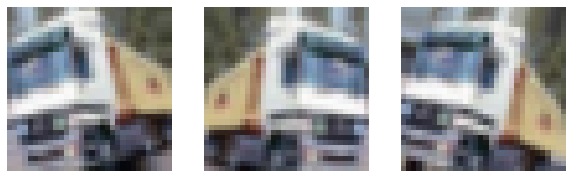

In [146]:
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    height_shift_range=0.1 )#Here we are flipping the image horizontally,shifting the image vertically by 0.1 and rotating the image by 15 degrees
image=X_train[1]
img = image.reshape((1, image.shape[0],image.shape[1],image.shape[2]))
plot_image(img,datagen)

we will be performong the data augmentation on the whole dataset in the below question as we send the entire data set through our combined model containg a pretrained model and our model which will be used as a output layer

<h2>Question 2</h2>

60 points) Transfer Learning: Show how to start with a pre-trained network architecture as the feature layers (featureizer), and alter that network to apply to your task (i.e., removing the output layers and adding your own). Experiment with at least two different feature layers (two different pre-trained networks). Compare them both in structure (show a diagram), talking about the relative complexity, number of parameters, etc., and also in the results you obtain. Which one worked better? Why do you think?

In [0]:
NUM_CLASSES = 10 # Since we have 10 classes in our cipher10 data set  
LEARNING_RATE = 1e-4# Learning rate for our model
MOMENTUM = 0.9
batch_Size=32

In [0]:
#Splitting our training data into training and Validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.20, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

In [0]:
Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
img_rows, img_cols , channels= 32,32,3
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, channels)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, channels)

In [0]:
datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1. / 255,
    )

In [0]:
train_generator = datagen.flow(X_train,Y_train, batch_size=32)
val_generator = datagen.flow(X_val,Y_val,batch_size=32)

**Using VGG16**

By taking the pretrained vggmodel using imagenet we have consider only the top 3 blocks of the vggmodel and then connected them to our model. We have frozen the weigths of the vgg layers and passed our augmented training data through it. As our pretrained model predicts the classes of the imagenet we have taken the output layers out and took the remaining layers in the vgg model. When we pass the training data through these layers we will get the output features. which will be inputs to our output layers

The input shape of the vgg16 we took is (32,32,3)(i.e 224/7,224/7,3).For VGG16 with input shape as (224,224,3) we will get output as (7,7,512), since we have taken input size as (32,32,3) our output will be (7/7,7/7,512) i.e(1,1,512)

VGG16 Model:

In [0]:
vggmodel = vgg.VGG16(weights='imagenet', 
                       include_top=False, input_shape=(32,32,3))#Vgg model pretrained with imagenet database,Here we have removed the output layer by writing down include_top=false

In [153]:
vggoutput = vggmodel.output#Getting the output from the VGG layer 
vggoutput

<tf.Tensor 'block5_pool_2/MaxPool:0' shape=(None, 1, 1, 512) dtype=float32>

Our Model

In [0]:
r = Flatten(name='Flatten')(vggoutput)# This layer is to flatten the output from the vgg
r = Dense(256, activation='relu')(r)#Simple dense layer with activation function as RELU  
r = Dropout(0.6)(r)#Dropout layer is used to reduce the overfitting
pred = Dense(NUM_CLASSES, activation='softmax')(r)#this will be the output layer giving the predicted output

**Freezing the weights of the vggmodel as we connect them to the output layers. The following section will cover both the step 1 and step**

In [0]:
for layer in vggmodel.layers:
     layer.trainable = False # Frreezing all the layers of our vgg16 model
model = Model(vggmodel.input, pred)# Our model which will be sequential 

In [156]:
# To check whether Vggmodel layers are trainable or not
for layer in  vggmodel.layers:
    print(layer, layer.trainable)


<keras.engine.input_layer.InputLayer object at 0x7f2a04f59978> False
<keras.layers.convolutional.Conv2D object at 0x7f2a04f593c8> False
<keras.layers.convolutional.Conv2D object at 0x7f2a04e4bc50> False
<keras.layers.pooling.MaxPooling2D object at 0x7f2a04f59eb8> False
<keras.layers.convolutional.Conv2D object at 0x7f2a04e56908> False
<keras.layers.convolutional.Conv2D object at 0x7f2a04f38748> False
<keras.layers.pooling.MaxPooling2D object at 0x7f2a04e77b70> False
<keras.layers.convolutional.Conv2D object at 0x7f2a04e779b0> False
<keras.layers.convolutional.Conv2D object at 0x7f2a04e0c6a0> False
<keras.layers.convolutional.Conv2D object at 0x7f2a04e0ce48> False
<keras.layers.pooling.MaxPooling2D object at 0x7f2a04dfbcc0> False
<keras.layers.convolutional.Conv2D object at 0x7f2a04dfbb00> False
<keras.layers.convolutional.Conv2D object at 0x7f2a04e02588> False
<keras.layers.convolutional.Conv2D object at 0x7f2a04e093c8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f2a04e09e10>

In [157]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])
"""
We are using loss function binary_crossentropy and optimizer as adam with learning rate of 0.0001 to compile our model
"""

'\nWe are using loss function binary_crossentropy and optimizer as adam with learning rate of 0.0001 to compile our model\n'

In [158]:
train_steps_per_epoch = X_train.shape[0] // batch_Size # Batch size of each epoch in our evaluation
print(X_train.shape[0])
val_steps_per_epoch = X_val.shape[0] // batch_Size
out= model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=10,
                              verbose=1)# Fitting our model using our training and validation data

40000
Epoch 1/10
1250/1250 [==============================] - 289s 231ms/step - loss: 0.2921 - accuracy: 0.9009 - val_loss: 0.2334 - val_accuracy: 0.9048
Epoch 2/10
1250/1250 [==============================] - 285s 228ms/step - loss: 0.2517 - accuracy: 0.9057 - val_loss: 0.2017 - val_accuracy: 0.9106
Epoch 3/10
1250/1250 [==============================] - 288s 230ms/step - loss: 0.2377 - accuracy: 0.9093 - val_loss: 0.1970 - val_accuracy: 0.9141
Epoch 4/10
1250/1250 [==============================] - 283s 227ms/step - loss: 0.2309 - accuracy: 0.9118 - val_loss: 0.2311 - val_accuracy: 0.9161
Epoch 5/10
1250/1250 [==============================] - 284s 227ms/step - loss: 0.2246 - accuracy: 0.9135 - val_loss: 0.2103 - val_accuracy: 0.9175
Epoch 6/10
1250/1250 [==============================] - 283s 227ms/step - loss: 0.2210 - accuracy: 0.9147 - val_loss: 0.2073 - val_accuracy: 0.9196
Epoch 7/10
1250/1250 [==============================] - 283s 227ms/step - loss: 0.2174 - accuracy: 0.9163 

***Fine-tuning the full network. In this section we will unfreeze all the layers of the vgg16 and then pass the training data through our combined model***

In [0]:
for layer in vggmodel.layers:
     layer.trainable = True # Unfrezing the weights of the vgg layers

In [389]:
for layer in  vggmodel.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f4e6b4c6f28> True
<keras.layers.convolutional.Conv2D object at 0x7f4e6b4c6f98> True
<keras.layers.convolutional.Conv2D object at 0x7f4e6b4cb400> True
<keras.layers.pooling.MaxPooling2D object at 0x7f4e6b4cb470> True
<keras.layers.convolutional.Conv2D object at 0x7f4e6b4cb6d8> True
<keras.layers.convolutional.Conv2D object at 0x7f4e6b4ca390> True
<keras.layers.pooling.MaxPooling2D object at 0x7f4e6b4caef0> True
<keras.layers.convolutional.Conv2D object at 0x7f4e6b4cad30> True
<keras.layers.convolutional.Conv2D object at 0x7f4e6a67df98> True
<keras.layers.convolutional.Conv2D object at 0x7f4e700165f8> True
<keras.layers.pooling.MaxPooling2D object at 0x7f4e70016e10> True
<keras.layers.convolutional.Conv2D object at 0x7f4e70016f98> True
<keras.layers.convolutional.Conv2D object at 0x7f4e7001cba8> True
<keras.layers.convolutional.Conv2D object at 0x7f4e6fff6748> True
<keras.layers.pooling.MaxPooling2D object at 0x7f4e6fff6f60> True
<keras.l

In [0]:
model = Model(vggmodel.input, pred)
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-6),
              metrics=['accuracy'])

In [367]:
train_steps_per_epoch = X_train.shape[0] // batch_Size
val_steps_per_epoch = X_val.shape[0] // batch_Size
out1 = model.fit_generator(train_generator,
                              steps_per_epoch=128,
                              validation_data=val_generator,
                              validation_steps=128,
                              epochs=10,
                              verbose=1)

Epoch 1/10
128/128 [==============================] - 67s 525ms/step - loss: 0.2320 - accuracy: 0.9201 - val_loss: 0.1648 - val_accuracy: 0.9343
Epoch 2/10
128/128 [==============================] - 66s 518ms/step - loss: 0.2077 - accuracy: 0.9250 - val_loss: 0.1391 - val_accuracy: 0.9385
Epoch 3/10
128/128 [==============================] - 71s 557ms/step - loss: 0.2007 - accuracy: 0.9271 - val_loss: 0.1921 - val_accuracy: 0.9420
Epoch 4/10
128/128 [==============================] - 67s 523ms/step - loss: 0.2018 - accuracy: 0.9265 - val_loss: 0.1671 - val_accuracy: 0.9412
Epoch 5/10
128/128 [==============================] - 66s 518ms/step - loss: 0.1973 - accuracy: 0.9260 - val_loss: 0.1892 - val_accuracy: 0.9419
Epoch 6/10
128/128 [==============================] - 67s 522ms/step - loss: 0.1884 - accuracy: 0.9303 - val_loss: 0.1412 - val_accuracy: 0.9416
Epoch 7/10
128/128 [==============================] - 67s 524ms/step - loss: 0.1885 - accuracy: 0.9287 - val_loss: 0.1635 - val_ac

In [85]:
model.summary()
"""
As we can see in the model we have removed the output layer if the vgg model and added our dense layers as output of the model.
"""

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

'\nAs we can see in the model we have removed the output layer if the vgg model and added our dense layers as output of the model.\n'

In [423]:
# Evaluating Testing Error of our model
model.evaluate(X_test,Y_test)

10000/10000 [==============================] - 51s 5ms/step


[1.81663344039917, 0.868310272693634]

As we can see from the above results we got an testing accuracy of 87 percent on our model

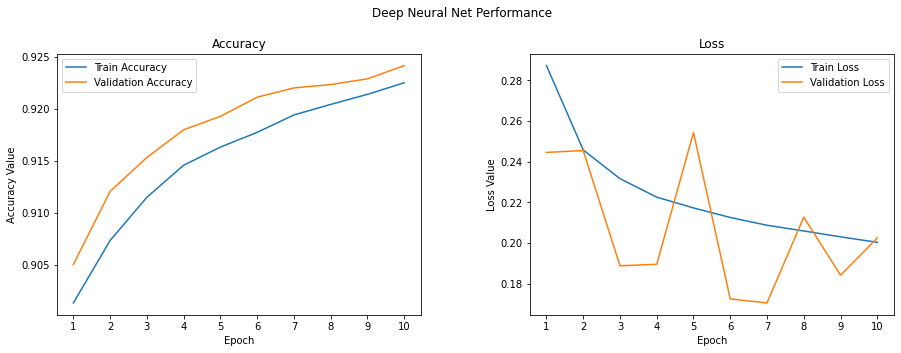

In [392]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epochs = list(range(1,10+1))
ax1.plot(epochs, out1.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, out1.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
ax2.plot(epochs, out1.history['loss'], label='Train Loss')
ax2.plot(epochs, out1.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

<h2>Using MobileNet</h2>
<li>In this section we will use Mobile net as our pretrained model and perform the same operations as we have done it for the VGG16.



In [0]:
from keras.applications.mobilenet import MobileNet#importing MobileNet
base_model1 = MobileNet(
        include_top=False,# removing the output layer
        weights='imagenet',# training our mobilenet model with the imagenet data
        input_shape=(32, 32, 3),# Input shape of our Mobilenew will be (32,32,3)
        )
#base_model1.summary()

In [56]:
# Extracting output features from the Mobilenet model
last1 = base_model1.output
last1

<tf.Tensor 'conv_pw_13_relu_2/Relu6:0' shape=(None, 1, 1, 1024) dtype=float32>

In [0]:
r1 = Flatten(name='Flatten')(last1)# TO flatten the output features of mobilenoe
r1 = Dense(256, activation='relu')(r1)# a Simple Dense layer with relu as the activation function
r1 = Dropout(0.6)(r1)# This layer is used to reduce the overfitting
pred1 = Dense(NUM_CLASSES, activation='softmax')(r1)# This layer is the output layer with activation function as softmax

In [58]:
model1 = Model(base_model1.input, pred1)#combining the mobilenet and the output layers
model1.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])
""
model1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 33, 33, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 16, 16, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 16, 16, 32)        128 

Freezing the layers of MobileNet in our combined model. The following section will cover the step 1 and step 2

In [0]:
for layer in base_model1.layers:
     layer.trainable = False# Freezing the weights of our mobilenet layers

In [60]:
#Checking whether our layers are trainable or not
for layer in  base_model1.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2a08f0f128> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f2a08f06b38> False
<keras.layers.convolutional.Conv2D object at 0x7f2a08f0f748> False
<keras.layers.normalization.BatchNormalization object at 0x7f2a08ee9550> False
<keras.layers.advanced_activations.ReLU object at 0x7f2a08f0f278> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f2a0a415da0> False
<keras.layers.normalization.BatchNormalization object at 0x7f2a08ee9d30> False
<keras.layers.advanced_activations.ReLU object at 0x7f2a08f56438> False
<keras.layers.convolutional.Conv2D object at 0x7f2a08f0bc50> False
<keras.layers.normalization.BatchNormalization object at 0x7f2a08e522b0> False
<keras.layers.advanced_activations.ReLU object at 0x7f2a08e64ef0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f2a08df7f98> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f2a08df7da0> False
<keras.layers.normalization.BatchNormalizati

In [0]:
model1 = Model(base_model1.input, pred1)
model1.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-6),
              metrics=['accuracy'])

In [63]:
train_steps_per_epoch = X_train.shape[0] // batch_Size
#print(X_val.shape[0])
val_steps_per_epoch = X_val.shape[0] // batch_Size
#validation_data=val_generator,validatio+n_steps=val_steps_per_epoch,
out3 = model1.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=10,
                              verbose=1)

Epoch 1/10
1250/1250 [==============================] - 63s 51ms/step - loss: 0.6615 - accuracy: 0.8456 - val_loss: 0.3256 - val_accuracy: 0.9000
Epoch 2/10
1250/1250 [==============================] - 64s 52ms/step - loss: 0.6300 - accuracy: 0.8475 - val_loss: 0.3239 - val_accuracy: 0.9000
Epoch 3/10
1250/1250 [==============================] - 64s 51ms/step - loss: 0.6051 - accuracy: 0.8501 - val_loss: 0.3244 - val_accuracy: 0.9000
Epoch 4/10
1250/1250 [==============================] - 64s 51ms/step - loss: 0.5853 - accuracy: 0.8516 - val_loss: 0.3231 - val_accuracy: 0.9000
Epoch 5/10
1250/1250 [==============================] - 65s 52ms/step - loss: 0.5679 - accuracy: 0.8531 - val_loss: 0.3235 - val_accuracy: 0.9000
Epoch 6/10
1250/1250 [==============================] - 64s 51ms/step - loss: 0.5473 - accuracy: 0.8552 - val_loss: 0.3222 - val_accuracy: 0.9000
Epoch 7/10
1250/1250 [==============================] - 65s 52ms/step - loss: 0.5339 - accuracy: 0.8566 - val_loss: 0.3257 -

In [64]:
model1.evaluate(X_test,Y_test)

10000/10000 [==============================] - 10s 1ms/step


[0.3244928896903992, 0.8999972939491272]

In this section we will unfreeze the weights of the mobileNet and then pass our training data through the combined model

In [0]:
for layer in base_model1.layers:
     layer.trainable = True # Unfreezing the layers of mobileNet

In [66]:
#To Check whether our mobilenet layers are trainable or not
for layer in  base_model1.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2a08f0f128> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f2a08f06b38> True
<keras.layers.convolutional.Conv2D object at 0x7f2a08f0f748> True
<keras.layers.normalization.BatchNormalization object at 0x7f2a08ee9550> True
<keras.layers.advanced_activations.ReLU object at 0x7f2a08f0f278> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f2a0a415da0> True
<keras.layers.normalization.BatchNormalization object at 0x7f2a08ee9d30> True
<keras.layers.advanced_activations.ReLU object at 0x7f2a08f56438> True
<keras.layers.convolutional.Conv2D object at 0x7f2a08f0bc50> True
<keras.layers.normalization.BatchNormalization object at 0x7f2a08e522b0> True
<keras.layers.advanced_activations.ReLU object at 0x7f2a08e64ef0> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f2a08df7f98> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f2a08df7da0> True
<keras.layers.normalization.BatchNormalization object at 

In [0]:
model1 = Model(base_model1.input, pred1)
model1.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-06),
              metrics=['accuracy'])# Taking less learning rate as we have to restrict the huge changes in the weights in the modelnet layers

In [69]:
train_steps_per_epoch = X_train.shape[0] // batch_Size
val_steps_per_epoch = X_val.shape[0] // batch_Size
out4 = model1.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=10,
                              verbose=1)

Epoch 1/10
1250/1250 [==============================] - 403s 322ms/step - loss: 0.4750 - accuracy: 0.8650 - val_loss: 0.3508 - val_accuracy: 0.8937
Epoch 2/10
1250/1250 [==============================] - 398s 319ms/step - loss: 0.4574 - accuracy: 0.8678 - val_loss: 0.3361 - val_accuracy: 0.8947
Epoch 3/10
1250/1250 [==============================] - 398s 318ms/step - loss: 0.4424 - accuracy: 0.8697 - val_loss: 0.3245 - val_accuracy: 0.8960
Epoch 4/10
1250/1250 [==============================] - 400s 320ms/step - loss: 0.4322 - accuracy: 0.8720 - val_loss: 0.3316 - val_accuracy: 0.8966
Epoch 5/10
1250/1250 [==============================] - 399s 319ms/step - loss: 0.4175 - accuracy: 0.8737 - val_loss: 0.3263 - val_accuracy: 0.8971
Epoch 6/10
1250/1250 [==============================] - 399s 319ms/step - loss: 0.4076 - accuracy: 0.8763 - val_loss: 0.3242 - val_accuracy: 0.8981
Epoch 7/10
1250/1250 [==============================] - 399s 319ms/step - loss: 0.3985 - accuracy: 0.8779 - val_

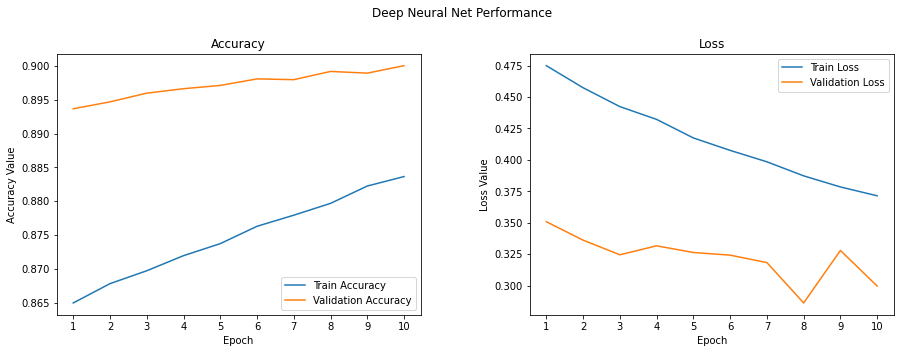

In [90]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,10+1))
ax1.plot(epochs, out4.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, out4.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, out4.history['loss'], label='Train Loss')
ax2.plot(epochs, out4.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [93]:
model1.evaluate(X_test,Y_test)

10000/10000 [==============================] - 10s 1ms/step


[0.3944008864402771, 0.8846596479415894]

As We can see from the results that the testing accuracy by using MobileNet is 89%

**Dataframe containing information about parameters of both the models**

In [98]:
lis1 = ['14,848,586','133,898','14,714,688']
lis2 = ['3,493,834','3,471,946','21,888']
mode = ['Total Parameters','Trainable Parameters','Non Trainable Parameters']
df1 = pd.DataFrame(list(zip(lis1, lis2,)), 
               columns =['Model with VSG', 'Model with MobileNet'],index=mode) 
df1

,Model with VSG,Model with MobileNet
Total Parameters,"14,848,586","3,493,834"
Trainable Parameters,"133,898","3,471,946"
Non Trainable Parameters,"14,714,688","21,888"


**Architecture of VGG16**

![alt text](https://)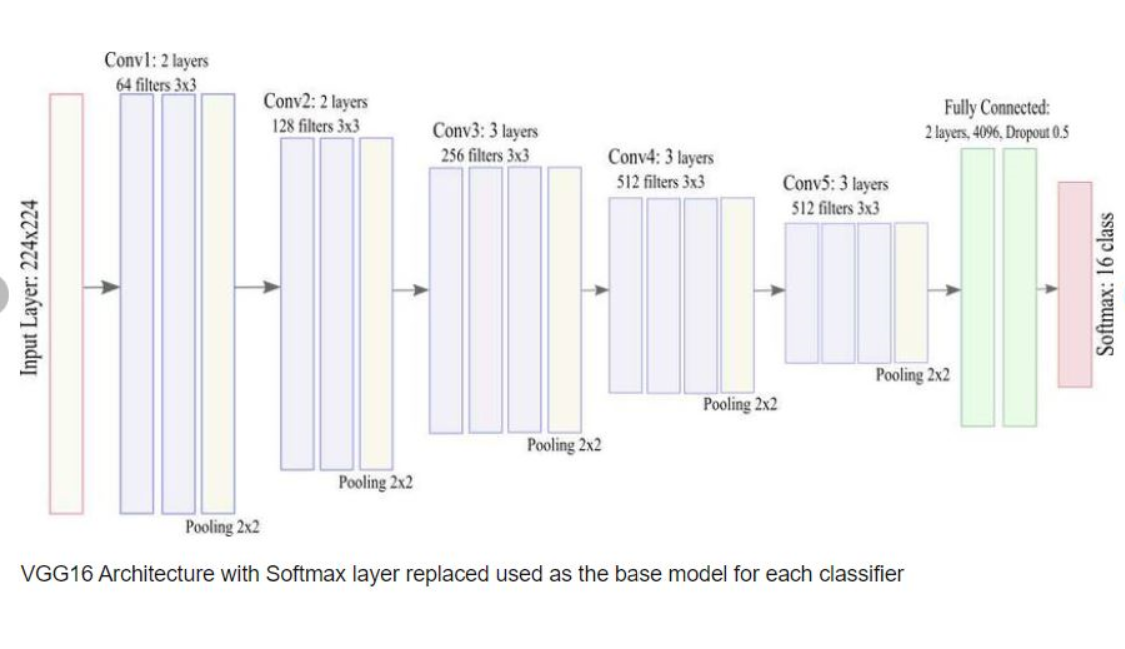



**VGG-16**
VGG16 is a convolutional neural network model. This model has the dataset of over 14 million images within 1000 classes and achieves 92.7% top-5 test accuracy in ImageNet. The input to cov1  layer has a fixed RGB image size of 224 x 224 x 3. The image is processed through a stack of convolutional layers using filters with a very small receptive field: 3x3. The convolution stride is fixe to 1 pixel; the spatial padding of convolution layer input is such that the spatial resolution is preserved after convolution, i.e. the 3x3 convolution laters has a padding of 1-pixel. The five max-pooling layers carries spatial pooling, which follow some of the convolution layers. Max-pooling is performed over 2x2 pixel window, with stride 2.Three Fully-Connected (FC) layers follow a stack of convolutional layers (which has a different depth in different architectures): the first two have 4096 channels each, the third performs 1000-way ILSVRC classification and thus contains 1000 channels (one for each class). The final layer is the soft-max layer. The configuration of the fully connected layers is the same in all networks. All hidden layers are equipped with the rectification (ReLU) non-linearity. It is also noted that none of the networks (except for one) contain Local Response Normalisation (LRN), such normalization does not improve the performance on the ILSVRC dataset, but leads to increased memory consumption and computation time.


**Architecture of MobileNET**

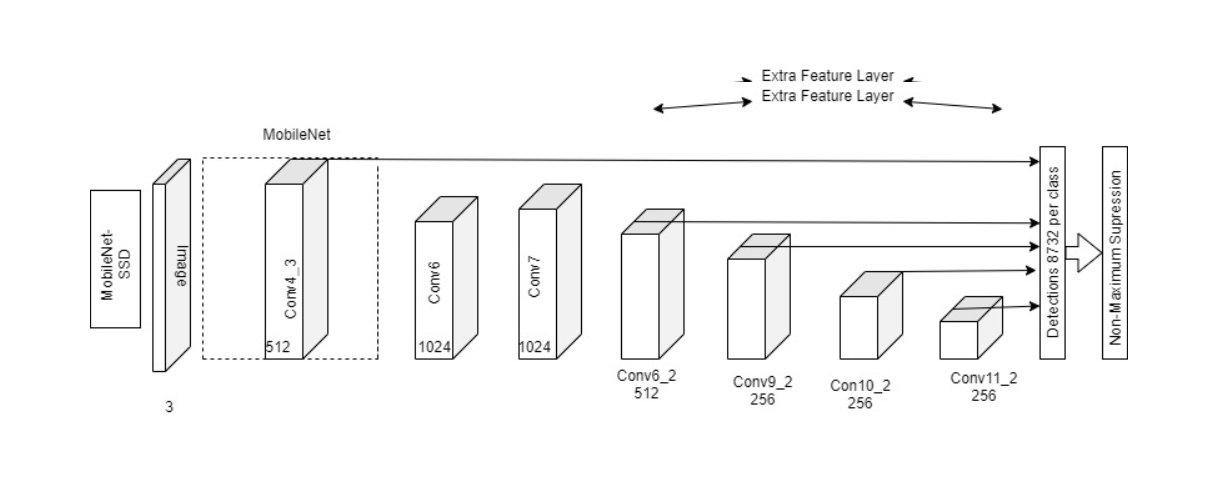

**MobileNets**

MobileNets uses depthwise separable convolutions to build lightweight deep neural networks which are based on a streamlined architecture. The MobileNet core layers are built on depthwise separable filters. The model is based on depthwise separable convolutions which are a form of a factorized convolutions which factorize a standard convolution into a depthwise convolution and a 1x1 convolution called a pointwise convolution. The depthwise convolution applies a single filter to each input channel for MobileNets. It then applies a 1x1 convolution to combine the depthwise convolution outputs. Both filters and inputs are combined into a new set of outputs in one step by Standard Convolution.
Depthwise separable convolutions are used to break the interaction between the size of the kernel and the number of output channels. The standard convolution operation has the effect of filtering the features using convolutional kernels and a new representation is produced by combining features. By using factorized convolutions, we split the filtering and combination steps called depthwise separable convolutions for a substantial reduction in computation cost. 

The architecture of the MobileNet is defined with the input layer size of 224x224x3 and an output later size of 7x7x1024. Every layer is followed by a batch norm and ReLU nonlinearity with the exception of the final fully connected layer which has no nonlinearity and feeds into a softmax layer for classification. As an effective base network, the MobileNet can be deployed in modern object detection systems.

**Comparision between VGG16 and MobileNet**

Even though MobileNet is 32x smaller and 10x faster than VGG16, it produces the same results, has the same accuracy, and more efficient in capturing knowledge than VGG. VGG needs way more connections than it needs in order to perform its job. There will be a tradeoff in network size vs.accuracy when you compress a neural network. The smaller the network, the faster it runs but worse in its predictions. For example, MobileNet scores better than SqueezeNet, but also 3.4 times larger.MobileNet has many convolutional layers like most mordern neural networks do. By sorting the weights for the layer from small to large and throwing away the connections with the smallest weights, we can compress a convolutional layer.

From the above results we can say that the model with Mobilenet gives us the better testing accuray. Mobilnet gives us the testing accuracy about 89% and Vgg gives us about 87%. Computational time of the mobilenet is less when compared to VGG. SO For the CIFAR Dataset Mobilenet gives us the better results than the VGG16.MobileNet is 32 times smaller than the VGG 16